# Imports

In [107]:
import pandas as pd
import os
from time import time
import ast
import h5py
import numpy as np
import seaborn as sns
from scipy import stats
from numpy.fft import fft, fftfreq
from sklearn.metrics import recall_score, make_scorer
from sklearn.model_selection import cross_validate
from scipy.stats import entropy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
pd.options.mode.chained_assignment = None
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, Concatenate, Activation, Add, GlobalAveragePooling1D, \
    Dense, LSTM, TimeDistributed, Reshape, BatchNormalization, Bidirectional, Flatten, MaxPooling1D, Dropout, \
    SeparableConv1D
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy, Reduction
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

LE_MAGIC_NUM = 42
rng = np.random.default_rng(LE_MAGIC_NUM)

os.environ['PYTHONHASHSEED'] = str(LE_MAGIC_NUM)

import random
random.seed(LE_MAGIC_NUM)

np.random.seed(LE_MAGIC_NUM)

tf.random.set_seed(LE_MAGIC_NUM)

In [108]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [109]:
tf.test.is_built_with_cuda()

True

# Utilities

In [110]:
def sensitivity_specificity(cf_matrix):
  if cf_matrix.shape[0] == 1:
    return np.array([1, 1])
  TN = cf_matrix[0][0]
  FP = cf_matrix[0][1]
  TP = cf_matrix[1][1]
  FN = cf_matrix[1][0]

  sensitivity = TP/(TP+FN) if TP & FN else 0
  specificity = TN/(TN+FP) if TN & FP else 0
  return sensitivity, specificity

def plot_history(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.figure(figsize=(20,4))
  plt.subplot(1,2,1)
  plt.plot(epochs, acc, label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation acc')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, loss, label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

def draw_confusion_matrix(cf_matrix):

  df_cm = pd.DataFrame(cf_matrix, index = [i for i in "01"],
                columns = [i for i in "01"])
  ax = plt.subplot()
  sns.heatmap(df_cm, annot=True, fmt = ".1f", ax=ax)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('True')
  TN = cf_matrix[0][0]
  FP = cf_matrix[0][1]
  TP = cf_matrix[1][1]
  FN = cf_matrix[1][0]
  print(f'Sensitivity: {TP/(TP+FN)}, Specificity: {TN/(TN+FP)}\n')
  # print(f'True positive samples: {TP} (These are the FOG samples we classified FOG)')
  # print(f'False positive samples: {FP} (These are normal samples we classified as FOG)')
  # print(f'True negative samples: {TN} (These are the normal samples we classified as normal)')
  # print(f'False negative samples: {FN} (These are the FOG samples we classified as normal)')
    
def windows(data, size):
    start = 0
    while start < len(data):
        yield int(start), int(start + size)
        start += (size / 2)


def segment(x, y, window_size, dataset_signals=9):
    #     print(f"X: {x.shape}\nY: {y.shape}\nWin_size: {window_size}\nSignals: {dataset_signals}")
    segments = np.zeros(((len(x) // (window_size // 2)) - 1, window_size, dataset_signals))
    labels = np.zeros(((len(y) // (window_size // 2)) - 1))
    i_segment = 0
    i_label = 0
    for (start, end) in windows(x, window_size):
        if len(x[start:end]) == window_size:
            m = stats.mode(y[start:end], keepdims=False)
            segments[i_segment] = x[start:end]
            labels[i_label] = m[0]
            i_label += 1
            i_segment += 1
    return segments, labels

def transform_y(y, nr_classes):
    # Transforms y, a list with one sequence of A timesteps
    # and B unique classes into a binary Numpy matrix of
    # shape (A, B)
    ybinary = to_categorical(y, nr_classes)
    return ybinary

# CNN-LSTM Model
def cnn_lstm(x_shape,
             n_classes,
             n_hidden=128,
             learning_rate=0.01,
             n_steps=4,
             length=32,
             n_signals=9,
             regularization_rate=0.01,
             cnn_depth=3,
             lstm_depth=2,
             metrics=['accuracy']):
    """ CNN1D_LSTM version 1: Divide 1 window into several smaller frames, then apply CNN to each frame
    - Input data format: [None, n_frames, n_timesteps, n_signals]"""

    _input_shape = x_shape[1:]
    m = Sequential()

    m.add(Reshape((n_steps, length, n_signals), input_shape=_input_shape))
    m.add(BatchNormalization())
    m.add(TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')))
    m.add(TimeDistributed(Conv1D(filters=64, kernel_size=5, activation='relu')))
    m.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    m.add(TimeDistributed(Conv1D(filters=64, kernel_size=5, activation='relu')))
    m.add(TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu')))
    m.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    m.add(TimeDistributed(Flatten()))
    for _ in range(lstm_depth-1):
        m.add(LSTM(n_hidden, return_sequences=True,
                   kernel_regularizer=l2(regularization_rate)))
    m.add(LSTM(n_hidden))
    m.add(Dropout(0.5))
    m.add(Dense(100, activation='relu',
                kernel_regularizer=l2(regularization_rate)))
    m.add(Dense(n_classes, activation=out_activ))

    m.compile(loss=out_loss,
              optimizer=Adam(learning_rate=learning_rate, amsgrad=True),
              metrics=metrics)
    return m


# Vanilla LSTM Model
def vanilla_lstm(x_shape,
                 n_classes,
                 n_hidden=128,
                 learning_rate=0.01,
                 regularization_rate=0.01,
                 metrics=['accuracy']):
    """ Requires 3D data: [n_samples, n_timesteps, n_signals]"""
    _input_shape = x_shape[1:]
    m = Sequential()

    m.add(BatchNormalization(input_shape=_input_shape))
    m.add(LSTM(n_hidden))
    m.add(Dropout(0.3))
    m.add(Dense(100, activation='relu'))
    m.add(Dense(n_classes, activation=out_activ, kernel_regularizer=l2(regularization_rate)))

    m.compile(loss=out_loss,
              optimizer=Adam(learning_rate=learning_rate),
              metrics=metrics)
    return m


# Stacked LSTM Model
def stacked_lstm(x_shape,
                 n_classes,
                 n_hidden=128,
                 learning_rate=0.01,
                 regularization_rate=0.01,
                 depth=2,
                 metrics=['accuracy']):
    """ Require 3D data: [n_samples, n_timesteps, n_signals]"""
    _input_shape = x_shape[1:]
    dim_length = x_shape[1]  # number of samples in a time series
    dim_channels = x_shape[2]  # number of channels
    dim_output = n_classes
    m = Sequential()

    m.add(BatchNormalization(input_shape=_input_shape))
    m.add(Dense(100, activation='relu', name='preprocess', kernel_regularizer=l2(regularization_rate)))
    m.add(LSTM(n_hidden, return_sequences=True, kernel_regularizer=l2(regularization_rate)))
    m.add(Dropout(0.5))
    m.add(LSTM(n_hidden))
    m.add(Dense(100, activation='relu'))
    m.add(Dense(dim_output, activation=out_activ, name="output"))

    m.compile(loss=out_loss,
              optimizer=Adam(learning_rate=learning_rate, amsgrad=True),
              metrics=metrics)
    return m


# BiLSTM Model
def bilstm(x_shape,
           n_classes,
           n_hidden=128,
           learning_rate=0.01,
           regularization_rate=0.01,
           merge_mode='concat',
           depth=2,
           metrics=['accuracy']):
    """ Requires 3D data: [n_samples, n_timesteps, n_features]"""

    _input_shape = x_shape[1:]
    m = Sequential()

    m.add(BatchNormalization(input_shape=_input_shape))
    m.add(Bidirectional(LSTM(n_hidden), merge_mode=merge_mode))
    m.add(Dense(100, activation='relu', kernel_regularizer=l2(regularization_rate)))
    m.add(Dense(n_classes, activation=out_activ))

    m.compile(loss=out_loss,
              optimizer=Adam(learning_rate=learning_rate, amsgrad=True),
              metrics=metrics)

    return m


# iSPLInception Model
def ispl_inception(x_shape,
                   n_classes,
                   filters_number,
                   network_depth=5,
                   use_residual=True,
                   use_bottleneck=True,
                   max_kernel_size=20,
                   learning_rate=0.01,
                   bottleneck_size=32,
                   regularization_rate=0.01,
                   metrics=['accuracy']):
    dim_length = x_shape[1]  # number of samples in a time series
    dim_channels = x_shape[2]  # number of channels
    weightinit = 'lecun_uniform'  # weight initialization

    def inception_module(input_tensor, stride=1, activation='relu'):

        # The  channel number is greater than 1
        if use_bottleneck and int(input_tensor.shape[-1]) > 1:
            input_inception = Conv1D(filters=bottleneck_size,
                                     kernel_size=1,
                                     padding='same',
                                     activation=activation,
                                     kernel_initializer=weightinit,

                                     use_bias=False)(input_tensor)
        else:
            input_inception = input_tensor

        kernel_sizes = [max_kernel_size // (2 ** i) for i in range(3)]
        conv_list = []

        for kernel_size in kernel_sizes:
            conv_list.append(Conv1D(filters=filters_number,
                                    kernel_size=kernel_size,
                                    strides=stride,
                                    padding='same',
                                    activation=activation,
                                    kernel_initializer=weightinit,
                                    kernel_regularizer=l2(regularization_rate),
                                    use_bias=False)(input_inception))

        max_pool_1 = MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

        conv_last = Conv1D(filters=filters_number,
                           kernel_size=1,
                           padding='same',
                           activation=activation,
                           kernel_initializer=weightinit,
                           kernel_regularizer=l2(regularization_rate),
                           use_bias=False)(max_pool_1)

        conv_list.append(conv_last)

        x = Concatenate(axis=2)(conv_list)
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)
        return x

    def shortcut_layer(input_tensor, out_tensor):
        shortcut_y = Conv1D(filters=int(out_tensor.shape[-1]),
                            kernel_size=1,
                            padding='same',
                            kernel_initializer=weightinit,
                            kernel_regularizer=l2(regularization_rate),
                            use_bias=False)(input_tensor)
        shortcut_y = BatchNormalization()(shortcut_y)

        x = Add()([shortcut_y, out_tensor])
        x = Activation('relu')(x)
        return x

    # Build the actual model:
    input_layer = Input((dim_length, dim_channels))
    x = BatchNormalization()(input_layer)  # Added batchnorm (not in original paper)
    input_res = x

    for depth in range(network_depth):
        x = inception_module(x)

        if use_residual and depth % 3 == 2:
            x = shortcut_layer(input_res, x)
            input_res = x

    gap_layer = GlobalAveragePooling1D()(x)

    # Final classification layer
    output_layer = Dense(n_classes, activation=out_activ,
                         kernel_initializer=weightinit, kernel_regularizer=l2(regularization_rate))(gap_layer)

    # Create model and compile
    m = Model(inputs=input_layer, outputs=output_layer)

    m.compile(loss=out_loss,
              optimizer=Adam(learning_rate=learning_rate, amsgrad=True),
              metrics=metrics)

    return m

# Read and Clean Data

Reading txt files as dataframes, adding headers

In [111]:
def load_dataset(dataset='daphnet', datapath='daphnet', _type='original'):
    datapath = datapath.rstrip("/")
    # Check if our desired dataset has not yet been generated
    if not os.path.exists(f'{datapath}/{dataset}.h5'):
        DataReader(dataset, datapath)

    # class labels
    with open(f'{datapath}/{dataset}.h5.classes.json', 'r') as f:
        labels = ast.literal_eval(f.read())

    with h5py.File(f'{datapath}/{dataset}.h5', 'r') as f:
        X_train, y_train = np.array(f['train']['inputs']), np.array(f['train']['targets'])
        X_val, y_val = np.array(f['validation']['inputs']), np.array(f['validation']['targets'])
        X_test, y_test = np.array(f['test']['inputs']), np.array(f['test']['targets'])

    return X_train, y_train, X_val, y_val, X_test, y_test, labels

X_train, y_train_int, X_val, y_val_int, X_test, y_test_int, labels = load_dataset()

In [112]:
n_signals = 9  # Ankle acc - x,y,z; Upper Leg acc - x,y,z; Trunk acc - x,y,z;
win_size = 192  # 1 sec -> 64 | 2.56 (3) sec -> 192 | 5 sec -> 320 # sampling rate = 64hz
n_classes = 2  # 1 - no freeze (walk, stand, turn); 2 - freeze
n_steps = 3  # Since we are using 3 seconds and 192 is divisible by 3
length = 64  # Split each window of 192 time steps into sub sequences for the cnn

X_train, y_train_int = segment(X_train, y_train_int, win_size, dataset_signals=n_signals)
X_val, y_val_int = segment(X_val, y_val_int, win_size, dataset_signals=n_signals)
X_test, y_test_int = segment(X_test, y_test_int, win_size, dataset_signals=n_signals)

y_train = transform_y(y_train_int, n_classes)
y_val = transform_y(y_val_int, n_classes)
y_test = transform_y(y_test_int, n_classes)

In [113]:
input_shape = X_train.shape

training_id = f'{time():.0f}'
out_loss = 'binary_crossentropy'
out_activ = 'sigmoid'
model_name = 'vanilla_lstm'
METRICS = ['accuracy']
save_name = os.path.abspath(f"models/daphnet/{training_id}/{model_name}.h5")
log_dir = os.path.abspath(f'logs/fit/daphnet/{training_id}/{model_name}')

if model_name == 'vanilla_lstm':
    # Give model specific configurations
    hyperparameters = {'n_hidden': 128, 'learning_rate': 0.0005, 'regularization_rate': 0.000093}
    epochs = 350
    # batch_size = 64
    mod_name = 'vLSTM'
    patience = 300

elif model_name == 'stacked_lstm':
    # Give model specific configurations
    hyperparameters = {'n_hidden': 128, 'learning_rate': 0.0005, 'regularization_rate': 0.000093,
                       'depth': 4}
    mod_name = 'sLSTM'
    epochs = 350
    patience = 150

elif model_name == 'bilstm':
    # Give model specific configurations
    hyperparameters = {'n_hidden': 128, 'learning_rate': 0.0005, 'regularization_rate': 0.000093,
                       'depth': 1,
                       'merge_mode': 'concat'}
    mod_name = 'BiLSTM'
    epochs = 350
    patience = 200

elif model_name == 'cnn':
    # Give model specific configurations
    hyperparameters = {'filters': [32, 64, 32], 'fc_hidden_nodes': 100, 'learning_rate': 0.0005,
                       'regularization_rate': 0.000093}
    mod_name = 'CNN'
    epochs = 350
    patience = 300

elif model_name == 'cnn_lstm':
    # Give model specific configurations
    hyperparameters = {'n_hidden': 512, 'n_steps': n_steps, 'length': length, 'n_signals': n_signals,
                       'learning_rate': 0.0005, 'cnn_depth': 3, 'lstm_depth': 2,
                       'regularization_rate': 0.000093}
    mod_name = 'CNN_LSTM'
    epochs = 350
    patience = 300

else:
    # Give default model specific configurations
    # Our default model is the iSPLInception model
    use_residual = True
    use_bottleneck = True
    hyperparameters = {'learning_rate': 0.0005, 'regularization_rate': 0.00593,
                       'network_depth': 5, 'filters_number': 64, 'max_kernel_size': 68,
                       'use_residual': use_residual, 'use_bottleneck': use_bottleneck}
    mod_name = 'iSPLInception'
    epochs = 350
    patience = 300

# Create and initialize the Model
model = eval(model_name + f"(input_shape, n_classes, metrics=METRICS, **hyperparameters)")

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_5 (Batc  (None, 192, 9)           36        
 hNormalization)                                                 
                                                                 
 lstm_5 (LSTM)               (None, 128)               70656     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               12900     
                                                                 
 dense_9 (Dense)             (None, 2)                 202       
                                                                 
Total params: 83,794
Trainable params: 83,776
Non-trainable params: 18
_________________________________________________

In [114]:
def evaluate_model(_model, _X_train, _y_train, _X_test, _y_test, _epochs=20, patience=10,
                   batch_size=64, _save_name='models/please_provide_a_name.h5', _log_dir='logs/fit'):
    """
    Returns the best trained model and history objects of the currently provided train & test set
    """
    early_stopping_monitor = EarlyStopping(patience=patience)

    checkpoint_path = _save_name
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create checkpoint callback
    cp_callback = ModelCheckpoint(checkpoint_path,
                                  monitor='val_loss',
                                  save_best_only=True,
                                  save_weights_only=False,
                                  verbose=0)
    # Tensorboard Callback
    tensorboard_callback = TensorBoard(log_dir=_log_dir, histogram_freq=1)

    # Reduce Learning rate after plateau
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.8, patience=10,
                                  min_lr=0.0001, verbose=1)

    # Training the model
    history = _model.fit(_X_train,
                         _y_train,
                         batch_size=batch_size,
                         validation_data=(_X_test, _y_test),
                         epochs=_epochs,
                         verbose=1,
                         # shuffle=True,
                         use_multiprocessing=True,
                         callbacks=[cp_callback, tensorboard_callback, early_stopping_monitor, reduce_lr])
    best_model = load_model(checkpoint_path)
    return best_model, history

model, history = evaluate_model(model, X_train, y_train, X_val, y_val, patience=patience,
                                                    _epochs=epochs, _save_name=save_name, _log_dir=log_dir)

Epoch 1/350
133/133 [==============================] - 10s 44ms/step - loss: 0.3768 - accuracy: 0.8649 - val_loss: 0.6081 - val_accuracy: 0.7383 - lr: 5.0000e-04
Epoch 2/350
133/133 [==============================] - 6s 42ms/step - loss: 0.3020 - accuracy: 0.8819 - val_loss: 0.5530 - val_accuracy: 0.7383 - lr: 5.0000e-04
Epoch 3/350
133/133 [==============================] - 5s 38ms/step - loss: 0.3020 - accuracy: 0.8820 - val_loss: 0.6765 - val_accuracy: 0.7383 - lr: 5.0000e-04
Epoch 4/350
133/133 [==============================] - 5s 40ms/step - loss: 0.2851 - accuracy: 0.8830 - val_loss: 0.5989 - val_accuracy: 0.7383 - lr: 5.0000e-04
Epoch 5/350
133/133 [==============================] - 5s 38ms/step - loss: 0.2938 - accuracy: 0.8800 - val_loss: 0.6006 - val_accuracy: 0.7383 - lr: 5.0000e-04
Epoch 6/350
133/133 [==============================] - 5s 38ms/step - loss: 0.2850 - accuracy: 0.8834 - val_loss: 0.5812 - val_accuracy: 0.7383 - lr: 5.0000e-04
Epoch 7/350
133/133 [============

KeyboardInterrupt: 

In [106]:
dataframes = dict(zip(range(1,11), [list() for x in range(1,11)]))
path = 'daphnet/dataset'
file_names = os.listdir(path)
col_names = ['time', 'ank_hor_fwd', 'ank_vert', 'ank_hor_lat', 'leg_hor_fwd', 'leg_vert', 'leg_hor_lat', 
             'trunk_hor_fwd', 'trunk_vert', 'trunk_hor_lat', 'label']
feature_col_names = col_names[1:10]

for name in file_names:
    splits = name.split('R')
    num = int(splits[0][1:])
    df = pd.read_csv(os.path.join(path,name),  delimiter=' ', names=col_names, header=None)

    # Remove instances where session hasn't started and decrement all labels by 1
    df = df[df['label'] != 0]
    df['label'] -= 1

    dataframes[num].append(df)

Remove patients 4 and 10 without any freezing episodes

In [6]:
# dataframes.pop(4)
# dataframes.pop(10)

In [7]:
dataframes[1][0]

,time,ank_hor_fwd,ank_vert,ank_hor_lat,leg_hor_fwd,leg_vert,leg_hor_lat,trunk_hor_fwd,trunk_vert,trunk_hor_lat,label
47999,750000,-30,990,326,-45,972,181,-38,1000,29,0
48000,750015,-30,1000,356,-18,981,212,-48,1028,29,0
48001,750031,-20,990,336,18,981,222,-38,1038,9,0
48002,750046,-20,1000,316,36,990,222,-19,1038,9,0
48003,750062,0,990,316,36,990,212,-29,1038,29,0
...,...,...,...,...,...,...,...,...,...,...,...
143995,2249937,-212,921,425,800,370,212,126,923,417,0
143996,2249953,-202,911,405,809,379,202,135,923,436,0
143997,2249968,-222,921,405,809,379,202,135,904,436,0
143998,2249984,-222,921,405,818,388,232,106,923,446,0


# Remove Outliers

In [8]:
dfs_no_outliers = dict(zip(dataframes.keys(), [list() for x in dataframes.keys()]))

for i, subject in dataframes.items():
    for j, session in enumerate(subject):
        features = session[feature_col_names]
        
        for col in features.columns:
            features[col][
              (features[col] < features[col].median(axis=0) - features[col].std(axis=0) * 4) |
              (features[col] > features[col].median(axis=0) + features[col].std(axis=0) * 4)
            ] = features[col].median()
        session.loc[:, feature_col_names] = features
        dfs_no_outliers[i].append(session)


In [9]:
dfs_no_outliers

{1: [           time  ank_hor_fwd  ank_vert  ank_hor_lat  leg_hor_fwd  leg_vert  \
  47999    750000          -30       990          326          -45       972   
  48000    750015          -30      1000          356          -18       981   
  48001    750031          -20       990          336           18       981   
  48002    750046          -20      1000          316           36       990   
  48003    750062            0       990          316           36       990   
  ...         ...          ...       ...          ...          ...       ...   
  143995  2249937         -212       921          425          800       370   
  143996  2249953         -202       911          405          809       379   
  143997  2249968         -222       921          405          809       379   
  143998  2249984         -222       921          405          818       388   
  143999  2250000         -212       921          435          818       370   
  
          leg_hor_lat  trunk_hor_f

# Feature Extraction

In [10]:
SAMPLE_RATE = 64 # Sample rate in herz
STEP_SIZE = 3 # Step size in samples
WINDOW_LENGTH = 192
POWER_THRESHOLD = 2 ** 12
# sensors = ['trunk_hor_fwd', 'trunk_vert', 'trunk_hor_lat']
sensors = ['ank_hor_fwd', 'ank_vert', 'ank_hor_lat', 'leg_hor_fwd', 'leg_vert', 'leg_hor_lat', 'trunk_hor_fwd', 'trunk_vert', 'trunk_hor_lat']

Iterates through each sensor axis in a 4-second window and extract 256 samples with a 32 step increment

In [17]:
def integrate(x, SR):
    return ( (sum(x[1:]) / SR) + (sum(x[:-1]) / SR) ) / 2

def is_standing(y):
    NFFT = WINDOW_LENGTH
    locomotion_band = [0.5, 3]
    freeze_band = [3, 8]

    f_res = SAMPLE_RATE / NFFT
    f_nr_LBs  = round(locomotion_band[0] / f_res) - 1 # -1 to match with baechlin's matlab functions (one indexed)
    f_nr_LBe  = round(locomotion_band[1] / f_res)
    f_nr_FBs  = round(freeze_band[0] / f_res) - 1
    f_nr_FBe  = round(freeze_band[1] / f_res)

    # Get signal inside window
    y -= y.mean() # Make signal zero-mean, removing DC component

    # Compute FFT and its real number equivalent
    Y = fft(y, NFFT)
    Pyy = Y * Y.conjugate()

    # Area Under Curve (AUC) of the locomotion and freeze band
    area_loco_band = integrate(Pyy[f_nr_LBs:f_nr_LBe].real / NFFT, SAMPLE_RATE)
    area_freeze_band = integrate(Pyy[f_nr_FBs:f_nr_FBe].real / NFFT, SAMPLE_RATE)

    return (area_loco_band + area_freeze_band) < POWER_THRESHOLD

def extract_features(data, labels):
    window_num = int(np.floor((len(data) - WINDOW_LENGTH + STEP_SIZE) / STEP_SIZE))

    # initialize feature dict
    windowed_data = np.full((window_num, WINDOW_LENGTH, len(sensors)), np.nan)
    window_labels = np.full(window_num, np.nan)

    current_pos = WINDOW_LENGTH;
    for i in range(window_num):
        start = current_pos - WINDOW_LENGTH
        window = data[start:current_pos]

        # uses trunk horizontal axis to check if subject is standing or actually freezing (Moore's idea) 
        #     if not is_standing(window['trunk_hor_fwd']):
        windowed_data[i] = window
        window_labels[i] = labels[start:current_pos].value_counts().index.values[0].astype(int)
        current_pos += STEP_SIZE
  
  return windowed_data, window_labels

In [12]:
def process_dataframes(dfs):
    subjects_dfs = dict(zip(dataframes.keys(), [pd.DataFrame() for x in dataframes.keys()]))
    # Iterate through dataset subjects, subject sessions and subject sensors' 
    # axis measurements in a session                    
    for i, subject in dfs.items():
        print(f'Patient {i}')

        subject_df = np.empty((1,WINDOW_LENGTH, len(sensors)))
        subject_df = np.delete(subject_df, (0), axis=0)
        subject_y = []

        for j, session_data in enumerate(subject):
            sensor_data = session_data.loc[:, sensors]
            print(f' Session {j}')

            session_windows, session_labels = extract_features(sensor_data, session_data['label'])
            subject_df = np.vstack((subject_df, session_windows))
            subject_y = np.concatenate((subject_y, session_labels), axis=0)

        window_num = subject_df.shape[0]
        subject_reshape = subject_df.reshape((window_num * WINDOW_LENGTH, len(sensors)))
        subject_no_nan = subject_reshape[~np.isnan(subject_reshape).any(axis=1)]
        clean_y = subject_y[~np.isnan(subject_y)]

        label_index = pd.MultiIndex.from_product([clean_y, np.arange(WINDOW_LENGTH)], names=['label','time_step'])
        subjects_dfs[i] = pd.DataFrame(subject_no_nan, columns=sensors, index=label_index)
    return subjects_dfs

windowed_dataframes = process_dataframes(dataframes)

Patient 1
 Session 0
 Session 1
Patient 2
 Session 0
 Session 1
Patient 3
 Session 0
 Session 1
 Session 2
Patient 5
 Session 0
 Session 1
Patient 6
 Session 0
 Session 1
Patient 7
 Session 0
 Session 1
Patient 8
 Session 0
Patient 9
 Session 0


In [13]:
windowed_dataframes

{1:                  ank_hor_fwd  ank_vert  ank_hor_lat  leg_hor_fwd  leg_vert  \
 label time_step                                                              
 0.0   0                -50.0     960.0        316.0       -127.0     935.0   
       1               -111.0     970.0        336.0       -127.0     953.0   
       2                -90.0    1019.0        326.0       -154.0     972.0   
       3                -70.0    1000.0        316.0       -145.0     962.0   
       4                -70.0     980.0        336.0       -109.0     972.0   
 ...                      ...       ...          ...          ...       ...   
       187             -202.0    1009.0        148.0        754.0     490.0   
       188             -212.0    1039.0        148.0        763.0     509.0   
       189             -212.0    1029.0        138.0        772.0     518.0   
       190             -222.0    1009.0        148.0        772.0     500.0   
       191             -212.0     990.0        16

In [14]:
freq_df = pd.concat(windowed_dataframes, names=['subject'])

In [15]:
freq_df

ank_hor_fwd  ank_vert  ank_hor_lat  leg_hor_fwd  \
subject label time_step                                                    
1       0.0   0                -50.0     960.0        316.0       -127.0   
              1               -111.0     970.0        336.0       -127.0   
              2                -90.0    1019.0        326.0       -154.0   
              3                -70.0    1000.0        316.0       -145.0   
              4                -70.0     980.0        336.0       -109.0   
...                              ...       ...          ...          ...   
9       0.0   187              191.0    1009.0        158.0       -645.0   
              188              191.0    1000.0        158.0       -636.0   
              189              191.0    1000.0        168.0       -627.0   
              190              202.0    1000.0        168.0       -636.0   
              191              202.0    1019.0        168.0       -645.0   

                         leg_vert  leg_hor_lat  trunk_hor_fwd  trunk_vert  \
subject label time_step                                                     
1       0.0   0             935.0        202.0          -29.0      1028.0   
              1             953.0        212.0          -19.0      1028.0   
              2             972.0        202.0          -19.0      1000.0   
              3             962.0        171.0          -29.0      1019.0   
              4             972.0        171.0          -48.0      1019.0   
...                           ...          ...            ...         ...   
9       0.0   187           453.0        595.0         -145.0       980.0   
              188           462.0        606.0         -155.0       980.0   
              189           444.0        616.0         -145.0       980.0   
              190           462.0        616.0         -155.0       980.0   
              191           453.0        616.0         -155.0       980.0   

                         trunk_hor_lat  
subject label time_step                 
1       0.0   0                    0.0  
              1                  -29.0  
              2                   -9.0  
              3                  -19.0  
              4                   -9.0  
...                                ...  
9       0.0   187                271.0  
              188                271.0  
              189                281.0  
              190                271.0  
              191                291.0  

[25122624 rows x 9 columns]

# Train Test Split

In [16]:
subjects = set(windowed_dataframes.keys())

TEST_NUM = 1

test_subjects = set(rng.choice(list(windowed_dataframes.keys()), TEST_NUM))
while len(test_subjects) != TEST_NUM:
    test_subjects = set(rng.choice(list(windowed_dataframes.keys()), TEST_NUM))
train_subjects = subjects - test_subjects

# least unbalanced subject goes to testing
# train_subjects = [1,2,3,5,6,7,8]
# test_subjects = [9]
train_subjects = [1,2,3,5,6,7,9]
test_subjects = [8]

print(train_subjects, test_subjects)

index_frame = freq_df.index.to_frame()

train_df = freq_df[index_frame['subject'].isin(train_subjects)]
test_df = freq_df[index_frame['subject'].isin(test_subjects)]

X_train = train_df.values.reshape((int(train_df.shape[0] / WINDOW_LENGTH), WINDOW_LENGTH, train_df.shape[1]))
X_test = test_df.values.reshape((int(test_df.shape[0] / WINDOW_LENGTH), WINDOW_LENGTH, test_df.shape[1]))

y_train = pd.Series(train_df.index.get_level_values(1).values.astype(int))
y_train = y_train[range(0, y_train.shape[0], WINDOW_LENGTH)]
y_test = pd.Series(test_df.index.get_level_values(1).values.astype(int))
y_test = y_test[range(0, y_test.shape[0], WINDOW_LENGTH)]

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

[1, 2, 3, 5, 6, 7, 9] [8]
(122064, 192, 9) (8783, 192, 9)
(122064,) (8783,)


In [17]:
y_test.value_counts()

0    6882
1    1901
dtype: int64

# Undersampling

In [18]:
y_train.value_counts()

0    99972
1    22092
dtype: int64

<AxesSubplot:>

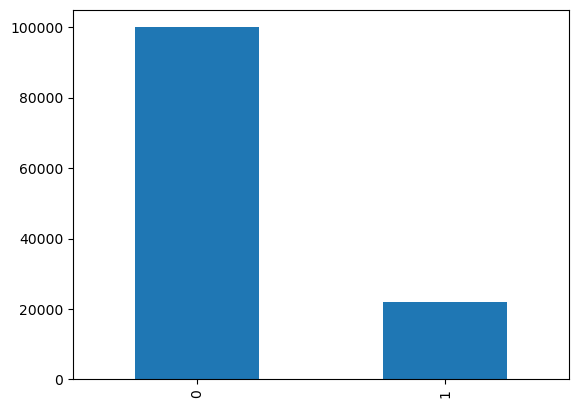

In [19]:
pd.Series(y_train.value_counts()).plot.bar()

In [20]:
def random_undersampling(X_train, y_train):
    lesser_label_value = y_train.value_counts()[1]
    y_zeros = y_train[y_train == 0]
    y_ones = y_train[y_train == 1]
    y_zeros_choice = rng.choice(y_train.index, lesser_label_value)
    
    y_train_zeros = np.zeros(lesser_label_value)
    X_train_zeros = X_train[np.floor(y_zeros_choice / WINDOW_LENGTH).astype(int), :, :]
    y_train_ones = np.ones(lesser_label_value)
    X_train_ones = X_train[np.floor(y_ones.index / WINDOW_LENGTH).astype(int), :, :]

    y_train_under = np.vstack((y_train_zeros.reshape(-1, 1), y_train_ones.reshape(-1, 1)))
    X_train_under = np.vstack([X_train_zeros, X_train_ones])
    X_train_under, y_train_under = shuffle(X_train_under, y_train_under, random_state=LE_MAGIC_NUM)
    y_train_under = pd.Series(y_train_under.reshape(-1))

    return X_train_under, y_train_under

X_train_under, y_train_under = random_undersampling(X_train, y_train)

<AxesSubplot:>

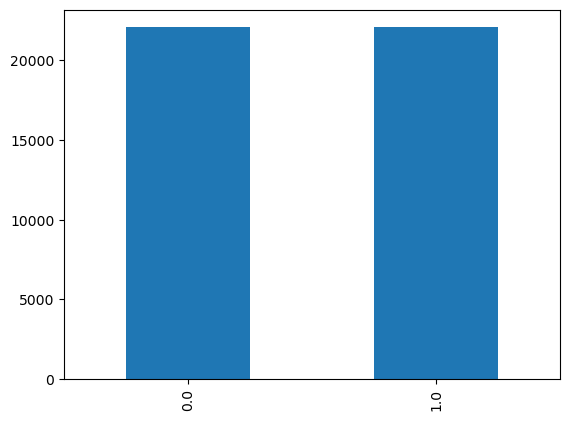

In [21]:
pd.Series(y_train_under.value_counts()).plot.bar()

In [22]:
X_train_under.shape
# y_train_under.shape

(44184, 192, 9)

# Training

In [23]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, MaxPool1D, Concatenate, Activation, Add, GlobalAveragePooling1D, \
    Dense, LSTM, TimeDistributed, Reshape, BatchNormalization, Bidirectional, Flatten, MaxPooling1D, Dropout, \
    SeparableConv1D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy, Reduction
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau


In [24]:
def ispl_inception(x_shape,
                   n_classes,
                   filters_number,
                   network_depth=5,
                   use_residual=True,
                   use_bottleneck=True,
                   max_kernel_size=20,
                   learning_rate=0.01,
                   bottleneck_size=32,
                   regularization_rate=0.01,
                   metrics=['accuracy']):
    dim_length = x_shape[1]  # number of samples in a time series
    dim_channels = x_shape[2]  # number of channels
    weightinit = 'lecun_uniform'  # weight initialization

    def inception_module(input_tensor, stride=1, activation='relu'):

        # The  channel number is greater than 1
        if use_bottleneck and int(input_tensor.shape[-1]) > 1:
            input_inception = Conv1D(filters=bottleneck_size,
                                     kernel_size=1,
                                     padding='same',
                                     activation=activation,
                                     kernel_initializer=weightinit,

                                     use_bias=False)(input_tensor)
        else:
            input_inception = input_tensor

        kernel_sizes = [max_kernel_size // (2 ** i) for i in range(3)]
        conv_list = []

        for kernel_size in kernel_sizes:
            conv_list.append(Conv1D(filters=filters_number,
                                    kernel_size=kernel_size,
                                    strides=stride,
                                    padding='same',
                                    activation=activation,
                                    kernel_initializer=weightinit,
                                    kernel_regularizer=l2(regularization_rate),
                                    use_bias=False)(input_inception))

        max_pool_1 = MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

        conv_last = Conv1D(filters=filters_number,
                           kernel_size=1,
                           padding='same',
                           activation=activation,
                           kernel_initializer=weightinit,
                           kernel_regularizer=l2(regularization_rate),
                           use_bias=False)(max_pool_1)

        conv_list.append(conv_last)

        x = Concatenate(axis=2)(conv_list)
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)
        return x

    def shortcut_layer(input_tensor, out_tensor):
        shortcut_y = Conv1D(filters=int(out_tensor.shape[-1]),
                            kernel_size=1,
                            padding='same',
                            kernel_initializer=weightinit,
                            kernel_regularizer=l2(regularization_rate),
                            use_bias=False)(input_tensor)
        shortcut_y = BatchNormalization()(shortcut_y)

        x = Add()([shortcut_y, out_tensor])
        x = Activation('relu')(x)
        return x

    # Build the actual model:
    input_layer = Input((dim_length, dim_channels))
    x = BatchNormalization()(input_layer)  # Added batchnorm (not in original paper)
    input_res = x

    for depth in range(network_depth):
        x = inception_module(x)

        if use_residual and depth % 3 == 2:
            x = shortcut_layer(input_res, x)
            input_res = x

    gap_layer = GlobalAveragePooling1D()(x)

    # Final classification layer
    output_layer = Dense(n_classes, activation='sigmoid',
                         kernel_initializer=weightinit, kernel_regularizer=l2(regularization_rate))(gap_layer)

    # Create model and compile
    m = Model(inputs=input_layer, outputs=output_layer)

    m.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate, amsgrad=True),
              metrics=metrics)

    return m

In [25]:
epochs = 350
patience = 300
use_residual = True
use_bottleneck = True
n_signals = 9  # Ankle acc - x,y,z; Upper Leg acc - x,y,z; Trunk acc - x,y,z;
win_size = 192  # 1 sec -> 64 | 2.56 (3) sec -> 192 | 5 sec -> 320 # sampling rate = 64hz
n_classes = 2  # 1 - no freeze (walk, stand, turn); 2 - freeze
n_steps = 3  # Since we are using 3 seconds and 192 is divisible by 3
length = 64  # Split each window of 192 time steps into sub sequences for the cnn
    
hyperparameters = {'learning_rate': 0.0005, 'regularization_rate': 0.00593,
                   'network_depth': 5, 'filters_number': 64, 'max_kernel_size': 68,
                   'use_residual': use_residual, 'use_bottleneck': use_bottleneck}
mod_name = 'iSPLInception'

model = ispl_inception(X_train.shape, 1, **hyperparameters)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 9)]     0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 192, 9)      36          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv1d (Conv1D)                (None, 192, 32)      288         ['batch_normalization[0][0]']    
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 192, 9)       0           ['batch_normalization[0][0]']

                                                                                                  
 conv1d_16 (Conv1D)             (None, 192, 32)      8192        ['activation_3[0][0]']           
                                                                                                  
 max_pooling1d_3 (MaxPooling1D)  (None, 192, 256)    0           ['activation_3[0][0]']           
                                                                                                  
 conv1d_17 (Conv1D)             (None, 192, 64)      139264      ['conv1d_16[0][0]']              
                                                                                                  
 conv1d_18 (Conv1D)             (None, 192, 64)      69632       ['conv1d_16[0][0]']              
                                                                                                  
 conv1d_19 (Conv1D)             (None, 192, 64)      34816       ['conv1d_16[0][0]']              
          

In [26]:
def evaluate_model(_model, _X_train, _y_train, _X_test, _y_test, _epochs=20, patience=10,
                   batch_size=64, _save_name='models/resnet', _log_dir='logs/fit'):
    """
    Returns the best trained model and history objects of the currently provided train & test set
    """
    early_stopping_monitor = EarlyStopping(patience=patience)

    checkpoint_path = _save_name
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create checkpoint callback
    cp_callback = ModelCheckpoint(checkpoint_path,
                                  monitor='val_loss',
                                  save_best_only=True,
                                  save_weights_only=False,
                                  verbose=0)
    # Tensorboard Callback
    tensorboard_callback = TensorBoard(log_dir=_log_dir, histogram_freq=1)

    # Reduce Learning rate after plateau
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.8, patience=10,
                                  min_lr=0.0001, verbose=1)

    # Training the model
    history = _model.fit(_X_train,
                         _y_train,
                         batch_size=batch_size,
                         validation_data=(_X_test, _y_test),
                         epochs=_epochs,
                         verbose=1,
                         # shuffle=True,
                         use_multiprocessing=True,
                         callbacks=[tensorboard_callback, early_stopping_monitor, reduce_lr])
    best_model = load_model(checkpoint_path)
    return best_model, history

In [27]:
model, history = evaluate_model(model, X_train, y_train, X_test, y_test, patience=patience, _epochs=epochs)
plot_history(history)
scores = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/350
1908/1908 [==============================] - 126s 58ms/step - loss: 0.9779 - accuracy: 0.9315 - val_loss: 0.7123 - val_accuracy: 0.7413 - lr: 5.0000e-04
Epoch 2/350
 380/1908 [====>.........................] - ETA: 1:25 - loss: 0.2281 - accuracy: 0.9598

KeyboardInterrupt: 

In [29]:
import h5py
mod = load_model('models/ispl_inception.h5')
mod.summary()

ImportError: DLL load failed while importing defs: The specified procedure could not be found.

In [ ]:
def build_model(X, summary):
    tf.keras.backend.clear_session()

    model = models.Sequential()
    n_timesteps, n_features = X.shape[1], X.shape[2]

    # Section 1
    model.add(layers.Conv1D(filters=50, kernel_size=33, activation='relu', input_shape=(n_timesteps, n_features)))
#                          kernel_initializer=tf.keras.initializers.he_uniform(seed=LE_MAGIC_NUM),
#                          kernel_regularizer=tf.keras.regularizers.l2(0.01),
#                          activity_regularizer=tf.keras.regularizers.l1(0.01)))
    model.add(layers.MaxPooling1D(pool_size=4, strides=2))

    # Section 2
    model.add(layers.Conv1D(filters=40, kernel_size=36, activation='relu',))
#                          kernel_initializer=tf.keras.initializers.he_uniform(seed=LE_MAGIC_NUM),
#                          kernel_regularizer=tf.keras.regularizers.l2(0.01),
#                          activity_regularizer=tf.keras.regularizers.l1(0.01)))
    model.add(layers.MaxPooling1D(pool_size=4, strides=2))

    # Section 3
    model.add(layers.Conv1D(filters=20, kernel_size=37, activation='relu'))
#                          kernel_initializer=tf.keras.initializers.he_uniform(seed=LE_MAGIC_NUM),
#                          kernel_regularizer=tf.keras.regularizers.l2(0.01),
#                          activity_regularizer=tf.keras.regularizers.l1(0.01)))
    model.add(layers.MaxPooling1D(pool_size=1, strides=2))

    # Section 4
#     model.add(layers.Conv1D(filters=100, kernel_size=1))
    model.add(layers.Flatten())
#     model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dropout(rate=0.5))
    model.add(layers.BatchNormalization(momentum=0.9))

    # Section 5
    model.add(layers.Dense(2, activation='softmax'))

    if summary:
        model.summary()

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

    return model

model = build_model(X_train_under, True)

In [ ]:
model = build_model(X_train_under, False)

def run_training(X, y, X_test, y_test, model, plot=False, verbose=0):
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=70, min_delta=0.005, restore_best_weights=False)
    history = model.fit(X, y, validation_data=(X_test, y_test), epochs=200, verbose=verbose, callbacks=[callback])
    if plot:
        plot_history(history)

run_training(X_train_under, y_train_under, X_test, y_test, model, plot=True, verbose=1)

321/321 [==============================] - 1s 2ms/step
(10255,) (10255,)
Sensitivity: 0.3652246256239601, Specificity: 0.8768309769456121



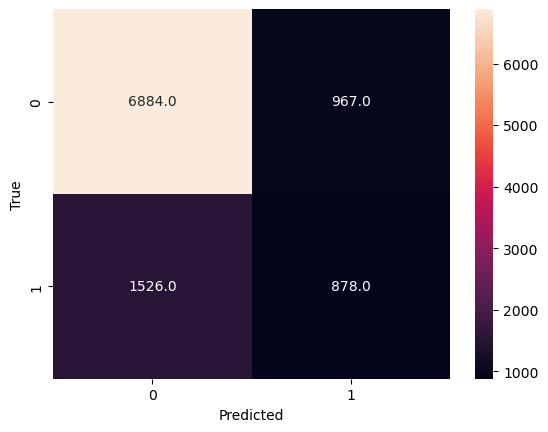

In [25]:
y_pred = model.predict(X_test).argmax(axis=1)
print(y_pred.shape, y_test.shape)
cf_matrix = confusion_matrix(y_test, y_pred)
draw_confusion_matrix(cf_matrix)
# Sensitivity: 0.5632279534109818, Specificity: 0.7223283658132722

In [26]:
model.save('./models/semi_supervised5672')

INFO:tensorflow:Assets written to: ./models/semi_supervised5672\assets


INFO:tensorflow:Assets written to: ./models/semi_supervised5672\assets



# Self-Training

In order to prevent some of the common pitfalls of self-labeling and self-training like wrong estimations with high confidence, we'll implement an algorithm called "Batch Learning" (Mikos, 2017).

## Representative Samples

First, we have to get representative samples from our dataset. This is obtained by calculating the euclidean distance between our dataset and its mean.

In [27]:
X = freq_df.values.reshape((int(freq_df.shape[0] / WINDOW_LENGTH), WINDOW_LENGTH, freq_df.shape[1]))
X.shape

(137745, 256, 9)

In [28]:
# Calculates euclidean distance for each columns in dataset, then sorts them to obtain the sample with smallest distance
distances = abs(X-X.mean(axis=0))

sorted_index = distances.sum(axis=1).sum(axis=1).argsort()
sorted_index

array([111377, 111376,   6761, ...,  24265,  24253,  24264], dtype=int64)

We collect a representative positive and negative sample, then calculate the euclidean distance between them and divide by 4 to create a "safe zone". During learning, any samples that falls inside a label's safe zone that has an opposite label is discarded. This mitigates the risk of the model deviating too much from the offline learning phase.

![title](images/safe_zone.png)

In [29]:
y_all = freq_df.index.get_level_values('label').values.astype(int)
y_all = y_all[range(0, y_all.shape[0], WINDOW_LENGTH)]
y_sorted = y_all[sorted_index]
y_sorted

array([0, 0, 0, ..., 1, 1, 1])

In [30]:
X_sorted = X[sorted_index]

In [31]:
neg_index = np.argwhere(y_sorted == 0)
pos_index = np.argwhere(y_sorted == 1)

X_sorted_neg = X_sorted[neg_index]
X_sorted_pos = X_sorted[pos_index]

rep_neg_sample = X_sorted_neg[0]
rep_pos_sample = X_sorted_pos[0]

print(rep_neg_sample.shape, rep_pos_sample.shape)

(1, 256, 9) (1, 256, 9)


In [32]:
safe_zone = abs(rep_neg_sample - rep_pos_sample) / 4
safe_zone

array([[[ 25.25,  61.25,  76.75, ...,  17.  ,   0.  ,  14.75],
        [111.  ,   7.5 ,  52.  , ...,   7.25,  31.  ,  29.25],
        [ 47.75,  14.75,  42.  , ...,  29.25,  50.  ,  31.5 ],
        ...,
        [ 25.25,  24.5 ,   5.  , ...,   7.25,   0.  ,  12.25],
        [ 58.  ,  14.75,  62.  , ...,   9.75,   9.75,  22.  ],
        [ 70.75,  10.  ,  32.25, ...,  12.25,   2.5 ,  14.5 ]]])

I'll also collect 5 representative samples which will be used in the batch learning phase so that the learning process isn't completely unsupervised  

In [33]:
X_offline_neg = X_sorted_neg[:5].reshape(-1, WINDOW_LENGTH, len(sensors))
X_offline_pos = X_sorted_pos[:5].reshape(-1, WINDOW_LENGTH, len(sensors))

# X_stack = np.vstack((rep_neg_samples, rep_pos_samples))
# y_stack = np.vstack((y_sorted[neg_index][:5], y_sorted[pos_index][:5]))
# X_rep, y_rep = shuffle(X_stack, y_stack)

# X_rep = X_rep.reshape(X_rep.shape[0], WINDOW_LENGTH, len(sensors))
# y_rep = y_rep.reshape(-1)

print(X_offline_neg.shape, X_offline_pos.shape)

(5, 256, 9) (5, 256, 9)


## Batch Learning

![title](images/learning_batch.png)

In [34]:
y_test.value_counts()

0    7851
1    2404
dtype: int64

In [35]:
pd.Series(model.predict(X_test).argmax(axis=1)).value_counts()

321/321 [==============================] - 1s 3ms/step


0    8410
1    1845
dtype: int64

In [36]:
print(pd.Series(y_pred).value_counts())

0    8410
1    1845
dtype: int64


In [37]:
X_test.shape[0]

10255

In [38]:
y_pred = []

num_samples = 10
shape = int(np.floor(X_test.shape[0] / num_samples))

for i in range(0, shape, num_samples):
    samples = X_test[i:i+num_samples]
    predictions = model.predict(samples, verbose=0)
#     highest_pred = predictions.argmax()
    y_pred = np.append(y_pred, predictions.argmax(axis=1))
#     prediction = predictions[highest_pred] if highest_pred == 1 else 1 - predictions[highest_pred]
print(pd.Series(y_pred).value_counts())
# print(i, shape)

0.0    1029
1.0       1
dtype: int64


Sensitivity: 0.3652246256239601, Specificity: 0.8768309769456121



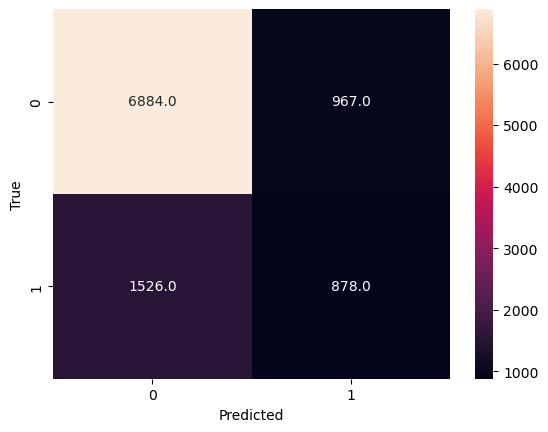

In [39]:
pred_y = np.zeros(X_test.shape[0])

for i, sample in enumerate(X_test):
    predictions = model.predict(np.array([sample]), verbose=0)[0]
    highest_pred = predictions.argmax()
    
    pred_y[i] = highest_pred

cf_matrix = confusion_matrix(y_test, pred_y)
draw_confusion_matrix(cf_matrix)

In [40]:
X_online_neg = []
X_online_pos = []

# Deep copy of offline training model
offline_model = tf.keras.models.clone_model(model)

y_pred = []
# for i, sample in enumerate(X_test[:10]):
#     predictions = offline_model.predict(np.array([sample]), verbose=0)[0]
#     highest_pred = predictions.argmax()
    
#     prediction = predictions[highest_pred] if highest_pred == 1 else 1 - predictions[highest_pred]
#     y_pred = np.append(y_pred, prediction)

y_pred = np.zeros(10)

for i, sample in enumerate(X_test[10:]):
    predictions = offline_model.predict(np.array([sample]), verbose=0)[0]
    highest_pred = predictions.argmax()
#     print(highest_pred, end=' ')

#     prediction = predictions[highest_pred] if highest_pred == 1 else 1 - predictions[highest_pred]
    if predictions[highest_pred] == 1:
        prediction = predictions[highest_pred]
    else:
        1 - predictions[highest_pred]
    
    pred_mean = np.array(y_pred[-3:]).mean()
#     print("(%.2f %d)" % (pred_mean.shape, y_test.iloc[i]))
    
#     if pred_mean > .55:
#         print('sus sus amogus')
#         y_pred = np.append(y_pred, prediction)
#         X_online_pos.append(sample)
#     elif pred_mean < .25:
#         y_pred = np.append(y_pred, prediction)
#         X_online_neg.append(sample)
#     else:
#         continue
    
    if len(X_online_pos) >= 5 and len(X_online_neg) >= 5:
        print("HORA DE TREINAR!")
        X_stack = np.vstack((X_online_pos[-5:], X_offline_pos, X_online_neg[-5:], X_offline_neg))
        y_stack = np.ravel((np.ones(10), np.zeros(10)))
        X_batch, y_batch = shuffle(X_stack, y_stack)
        print(X_batch.shape, y_batch.shape)
        offline_model.fit(X_batch, y_batch, epochs=200, batch_size=20, verbose=0)
        # Remove os últimos 5 de cada array
        X_online_pos = X_online_pos[:-5]
        X_online_neg = X_online_neg[:-5]

#     Não dá pra aplicar o Rep Sample, porque eu tirei a média da base inteira e não em batch 256. 
#     Preciso encontrar o batch 256 que é média, se é que isso faz sentido
#     if highest_pred == 1 and np.all(sample > rep_pos_sample + safe_zone or sample < rep_pos_sample - safe_zone):
#         break
#     elif highest_pred == 0 and np.all(sample > rep_neg_sample + safe_zone or sample < rep_pos_sample - safe_zone):
#         break
#     break

# 'Leave One Out' Cross Validation

In [41]:
frame = freq_df.index.to_frame()
freq_df[frame['subject'].isin(train_subjects)]

ank_hor_fwd  ank_vert  ank_hor_lat  leg_hor_fwd  \
subject label time_step                                                    
1       0.0   0               -101.0     980.0        326.0       -136.0   
              1                -80.0    1000.0        326.0       -100.0   
              2                -70.0     990.0        336.0        -81.0   
              3                -90.0     990.0        306.0        -81.0   
              4                -50.0     990.0        316.0       -100.0   
...                              ...       ...          ...          ...   
9       0.0   251              191.0     990.0        158.0       -627.0   
              252              191.0    1000.0        158.0       -636.0   
              253              171.0    1000.0        178.0       -636.0   
              254              191.0    1009.0        148.0       -636.0   
              255              191.0    1009.0        148.0       -627.0   

                         leg_vert  leg_hor_lat  trunk_hor_fwd  trunk_vert  \
subject label time_step                                                     
1       0.0   0             972.0        181.0          -48.0      1019.0   
              1             962.0        181.0          -58.0      1019.0   
              2             972.0        212.0          -58.0      1009.0   
              3             981.0        202.0          -58.0      1009.0   
              4             962.0        202.0          -48.0      1028.0   
...                           ...          ...            ...         ...   
9       0.0   251           444.0        595.0         -155.0       961.0   
              252           472.0        606.0         -145.0       980.0   
              253           462.0        616.0         -135.0       980.0   
              254           453.0        616.0         -145.0       971.0   
              255           453.0        616.0         -145.0       980.0   

                         trunk_hor_lat  
subject label time_step                 
1       0.0   0                   -9.0  
              1                  -58.0  
              2                    0.0  
              3                    0.0  
              4                  -29.0  
...                                ...  
9       0.0   251                281.0  
              252                242.0  
              253                271.0  
              254                262.0  
              255                252.0  

[32637440 rows x 9 columns]

In [42]:
sensitivity_scores = []
specificity_scores = []
total_cf_matrix = np.zeros((2,2))

for test_subject in subjects:
    train_subjects = subjects - set([test_subject])
    train_df = all_df.loc[train_subjects].droplevel('subject')
    test_df = all_df.loc[test_subject]
    break

    X_train = train_df.values.reshape((int(train_df.shape[0] / WINDOW_LENGTH), WINDOW_LENGTH, train_df.shape[1]))
    X_test = test_df.values.reshape((int(test_df.shape[0] / WINDOW_LENGTH), WINDOW_LENGTH, test_df.shape[1]))
    y_train = all_y.loc[train_subjects].reset_index(drop=True)
    y_test = all_y.loc[test_subject].reset_index(drop=True)

    X_train_under, y_train_under = random_undersampling(X_train, y_train)

    model = build_model(X_train_under, False)
    run_training(X_train_under, y_train_under, X_test, y_test, model, plot=False, verbose=0)

    y_pred = model.predict(X_test).argmax(axis=1)
    cf_matrix = confusion_matrix(y_test, y_pred)
    total_cf_matrix += cf_matrix
    sensitivity, specificity = sensitivity_specificity(cf_matrix)
    sensitivity_scores.append(sensitivity)
    specificity_scores.append(specificity)

    tf.keras.backend.clear_session()
    print('The results for test subject {:} are Sensitivity {:.2%} and Specificity {:.2%}'.format(test_subject, sensitivity, specificity))

NameError: name 'all_df' is not defined

In [ ]:
df = pd.DataFrame({'id':list(subjects), 'Sensitivity':sensitivity_scores, 'Specificity':specificity_scores})

df.plot(x="id", y=["Sensitivity", 'Specificity'], kind="bar")

In [ ]:
print('Average Sensitivity {:.2%} and Specificity {:.2%}'.format(sum(sensitivity_scores) / len(sensitivity_scores), sum(specificity_scores) / len(specificity_scores)))

In [ ]:
draw_confusion_matrix(total_cf_matrix)